# Create model dataset
<br>
This file is used to create training and test data for a edge detecrtion machine learning models. It crops the AOI tif files and vegetation shape files. 

In [19]:
import os
import glob
import numpy as np
import pandas as pd

import rasterio
from rasterio.plot import show
from rasterio.features import rasterize
from shapely.geometry import LineString

import matplotlib.pyplot as plt
import cv2

import geopandas as gpd
import random


# reimport 
import utils 
import importlib
importlib.reload(utils)

data_path = "/Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/data"

In [ ]:
processed_files = pd.read_csv("../data/meta/processed_files.csv")
processed_files['ID'] = [f.split('_')[2] for f in processed_files['filename']]
processed_files.head(5)

In [ ]:
tif_files = glob.glob(os.path.join(data_path, "processed/aoi_crop", "*.tif"))
len(tif_files)

In [ ]:
veg_lines_path = os.path.join(data_path, "QGIS/Vegetation Lines Howth/vegetation_lines_howth.shp")
print(veg_lines_path)
veg_lines = gpd.read_file(veg_lines_path)
veg_lines.head(10)

In [ ]:
raster =rasterio.open(tif_files[4])
print(raster.crs)

In [ ]:
veg_line = veg_lines[(veg_lines['ID'] == '20240812T114351') &
                     (veg_lines['line'] == 2)]

# convert to series 
veg_line = veg_line.iloc[0]
# show crs
print(type(veg_line))
veg_line

In [2]:
def get_line_mask(raster,line):
    """
    Get a mask of the line in the raster
    """
    line_mask = rasterize(
        [line.geometry],
        out_shape=raster.shape,
        transform=raster.transform,
        fill=0,
        dtype='uint8'
    )
    return line_mask

In [ ]:


line_mask = get_line_mask(raster,veg_line)

print(line_mask.shape)
print(np.unique(line_mask))
line_mask

In [4]:
def get_points(line,m=100):
    """
    Convert a shapely geometry to a list of points
    """
   
    length = line.geometry.length

    # Get points every m meters along the line
    num_points = int(length / m)
    points = [line.geometry.interpolate(distance, normalized=False) 
            for distance in np.linspace(0, length, num_points)]

    return points

In [ ]:


points = get_points(raster,veg_line,m=100)
print(len(points))
points[0]

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

rgb = raster.read()
rgb = utils.get_rgb(rgb ,contrast=0.3)
print(rgb.shape)
ax[0].imshow(rgb)

x1,x2,y1,y2 = 2000,2500,9000,9500

# add square
ax[0].add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', lw=1))
for point in points:
    utmx, utmy = point.x, point.y
    y, x = raster.index(utmx, utmy)
    ax[0].add_patch(plt.Circle((x, y), 1, color='blue', alpha=1))
    #ax[0].text(x, y, str(i), fontsize=8, color='white')
#ax[0].axis('off')

rgb_crop = rgb[y1:y2, x1:x2, :]
line_mask_crop = line_mask[y1:y2, x1:x2]
ax[1].imshow(rgb_crop)
ax[1].imshow(line_mask_crop, alpha=0.5, cmap='gray')
for point in points:
    utmx, utmy = point.x, point.y
    y, x = raster.index(utmx, utmy)
    ax[1].add_patch(plt.Circle((x-x1, y-y1), 1, color='blue', alpha=1))
    #ax[1].text(x-x1, y-y1, str(i), fontsize=8, color='white')


In [14]:
import numpy as np
from rasterio.windows import Window


def get_crops(raster, mask, points,crop_size=144,augmentation=True):
    instances = []

    for point in points:
        # Get the pixel coordinates of the point
        utmx, utmy = point.x, point.y
        y, x = raster.index(utmx, utmy)

        # Get cropped window centered around the point
        window_x = x - crop_size // 2 
        window_y = y - crop_size // 2

        # Offset the window by a random amount within the crop size
        window_x += np.random.randint(-crop_size // 2, crop_size // 2) 
        window_y += np.random.randint(-crop_size // 2, crop_size // 2)

        # Define the window for cropping
        window = Window(window_x, window_y, crop_size, crop_size)
        
        # Read 4-band image crop
        img_crop = raster.read(window=window)[0:4, :, :]
        
        # Extract corresponding mask crop
        mask_crop = mask[window_y:window_y+crop_size, window_x:window_x+crop_size]
        # Add a channel dimension to the mask crop
        mask_crop = np.expand_dims(mask_crop, axis=0)
        
       
        if augmentation:
            # Randomly flip the image and mask crops
            if np.random.rand() > 0.5:
                img_crop = np.flip(img_crop, axis=1) #axis 0 is bands, axis 1 is y, axis 2 is x
                mask_crop = np.flip(mask_crop, axis=1)
            if np.random.rand() > 0.5:
                img_crop = np.flip(img_crop, axis=2)
                mask_crop = np.flip(mask_crop, axis=2)
            
            # Randomly rotate the image and mask crops
            angle = np.random.choice([0, 90, 180, 270])
            img_crop = np.rot90(img_crop, k=angle//90, axes=(1, 2))
            mask_crop = np.rot90(mask_crop, k=angle//90, axes=(1, 2))

        instance = np.concatenate([img_crop, mask_crop], axis=0)
        instances.append(instance)

    return instances

#instances = get_crops(raster, line_mask, points,augmentation=True)

In [ ]:
fig,ax = plt.subplots(1, 3, figsize=(10, 5))
img_crop = instances[1][0:3, :, :]
mask_crop = instances[1][4:5, :, :][0]
rgb = utils.get_rgb(img_crop, contrast=0.3)
ax[0].imshow(rgb)
ax[0].imshow(mask_crop, alpha=0.5, cmap='gray')

flip_crop = np.flip(img_crop, axis=1)
flip_mask = np.flip(mask_crop, axis=0)
ax[1].imshow(utils.get_rgb(flip_crop, contrast=0.3))
ax[1].imshow(flip_mask, alpha=0.5, cmap='gray')

flip_crop = np.flip(img_crop, axis=2)
flip_mask = np.flip(mask_crop, axis=1)
ax[2].imshow(utils.get_rgb(flip_crop, contrast=0.3))
ax[2].imshow(flip_mask, alpha=0.5, cmap='gray')


In [ ]:
fig,ax = plt.subplots(1, 5, figsize=(10, 5))
img_crop = instances[1][0:3, :, :]
mask_crop = instances[1][4:5, :, :][0]
rgb = utils.get_rgb(img_crop, contrast=0.3)
ax[0].imshow(rgb)
ax[0].imshow(mask_crop, alpha=0.5, cmap='gray')

angles = [0, 90, 180, 270]
for i, angle in enumerate(angles):
    rot_img = np.rot90(img_crop, k=angle//90, axes=(1, 2))
    rot_mask = np.rot90(mask_crop, k=angle//90, axes=(0, 1))
    rgb = utils.get_rgb(rot_img, contrast=0.3)
    ax[i+1].imshow(rgb)
    ax[i+1].imshow(rot_mask, alpha=0.5, cmap='gray')

    ax[i+1].set_title(f"Angle: {angle}°")
    ax[i+1].axis('off')

In [ ]:
fig,ax = plt.subplots(10, 5, figsize=(10, 20))
ax = ax.flatten().flatten()
for i in range(49):
    img_crop = instances[i][0:3, :, :]
    mask_crop = instances[i][4:5, :, :][0]
    rgb = utils.get_rgb(img_crop, contrast=0.3)
    ax[i].imshow(rgb)
    ax[i].imshow(mask_crop, alpha=0.5, cmap='gray')
    ax[i].axis('off')

### Training data

In [7]:
processed_files = pd.read_csv("../data/meta/processed_files.csv")
processed_files['ID'] = [f.split('_')[2] for f in processed_files['filename']]

processed_files['year'] = [int(d[0:4]) for d in processed_files['date']]

training_files = processed_files[(processed_files['year'] == 2024) |
                                    (processed_files['year'] == 2016)]
print(len(training_files))

# get random date in each year for test dataset

#set random seed
np.random.seed(18)
test_dates = training_files.groupby('year').apply(lambda x: x.sample(1)).reset_index(drop=True)
test_dates = test_dates['date']
print(test_dates)

18
0    2016-06-02
1    2024-08-14
Name: date, dtype: object


/var/folders/_j/wkrsnnnn2lj6cds3dhhlkkh40000gn/T/ipykernel_57153/1389064963.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_dates = training_files.groupby('year').apply(lambda x: x.sample(1)).reset_index(drop=True)


In [16]:
veg_lines_path = os.path.join(data_path, "QGIS/Vegetation Lines Howth/vegetation_lines_howth.shp")
veg_lines = gpd.read_file(veg_lines_path)
print("Number of veg lines:",len(veg_lines))


for row in processed_files.iterrows():

    row = row[1]
    
    filename = row['filename']
    ID = row['ID']

    # Get raster 
    tif_filename = filename + "_AOI.tif"
    tif_filepath = os.path.join(data_path, "processed/aoi_crop", tif_filename)

    if not os.path.exists(tif_filepath):
        print("File does not exist:", tif_filepath)
        continue

    raster =rasterio.open(tif_filepath)

    # Get vegetation line
    veg_lines_id = veg_lines[veg_lines['ID'] == ID]
    veg_line_1 = veg_lines_id[veg_lines_id['line'] == 1] #howth
    veg_line_2 = veg_lines_id[veg_lines_id['line'] == 2] #portrane
    assert len(veg_line_1) == 1
    assert len(veg_line_2) == 1

    # convert to series
    veg_line_1 = veg_line_1.iloc[0]
    veg_line_2 = veg_line_2.iloc[0]


    points_1 = get_points(veg_line_1)
    points_2 = get_points(veg_line_2)


    # get line mask
    line_mask_1 = get_line_mask(raster,veg_line_1)
    line_mask_2 = get_line_mask(raster,veg_line_2)


    # get crops
    instances_1 = get_crops(raster, line_mask_1, points_1,augmentation=True)
    instances_2 = get_crops(raster, line_mask_2, points_2,augmentation=True)
    assert len(instances_1) > 0
    assert len(instances_2) > 0

    print("ID:", ID,
          "Line 1:", len(instances_1),
          "Line 2:", len(instances_2))

    save_dir = os.path.join(data_path, "SIVE/training")
    if row['date'] in test_dates.values:
        save_dir = os.path.join(data_path, "SIVE/test")

    for i, instance in enumerate(instances_1):
        assert instance.shape == (5, 144, 144)
        save_path = os.path.join(save_dir, f"{filename}_line1_{i}.npy")
        np.save(save_path, instance)
    for i, instance in enumerate(instances_2):
        assert instance.shape == (5, 144, 144)
        save_path = os.path.join(save_dir, f"{filename}_line2_{i}.npy")
        np.save(save_path, instance)

Number of veg lines: 40
ID: 20240918T113321 Line 1: 49 Line 2: 46
ID: 20240916T114349 Line 1: 49 Line 2: 46
ID: 20240906T114349 Line 1: 49 Line 2: 46
ID: 20240814T113319 Line 1: 48 Line 2: 46
ID: 20240812T114351 Line 1: 49 Line 2: 49
ID: 20240723T114351 Line 1: 48 Line 2: 49
ID: 20240708T114349 Line 1: 49 Line 2: 50
ID: 20240623T114351 Line 1: 49 Line 2: 46
ID: 20240516T113319 Line 1: 49 Line 2: 50
File does not exist: /Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/data/processed/aoi_crop/S2A_MSIL2A_20240501T113321_N0510_R080_T29UPV_20240501T171752_AOI.tif
ID: 20240421T113321 Line 1: 49 Line 2: 49
File does not exist: /Users/conorosullivan/Documents/git/COASTAL_MONITORING/sentinel2-irish-coastal-segmentation/data/processed/aoi_crop/S2A_MSIL2A_20160930T113312_N0500_R080_T29UPV_20231002T233148_AOI.tif
ID: 20160920T113312 Line 1: 52 Line 2: 50
ID: 20160824T114352 Line 1: 52 Line 2: 50
ID: 20160605T114352 Line 1: 40 Line 2: 49
ID: 20160602T11332

Number of training files: 1653


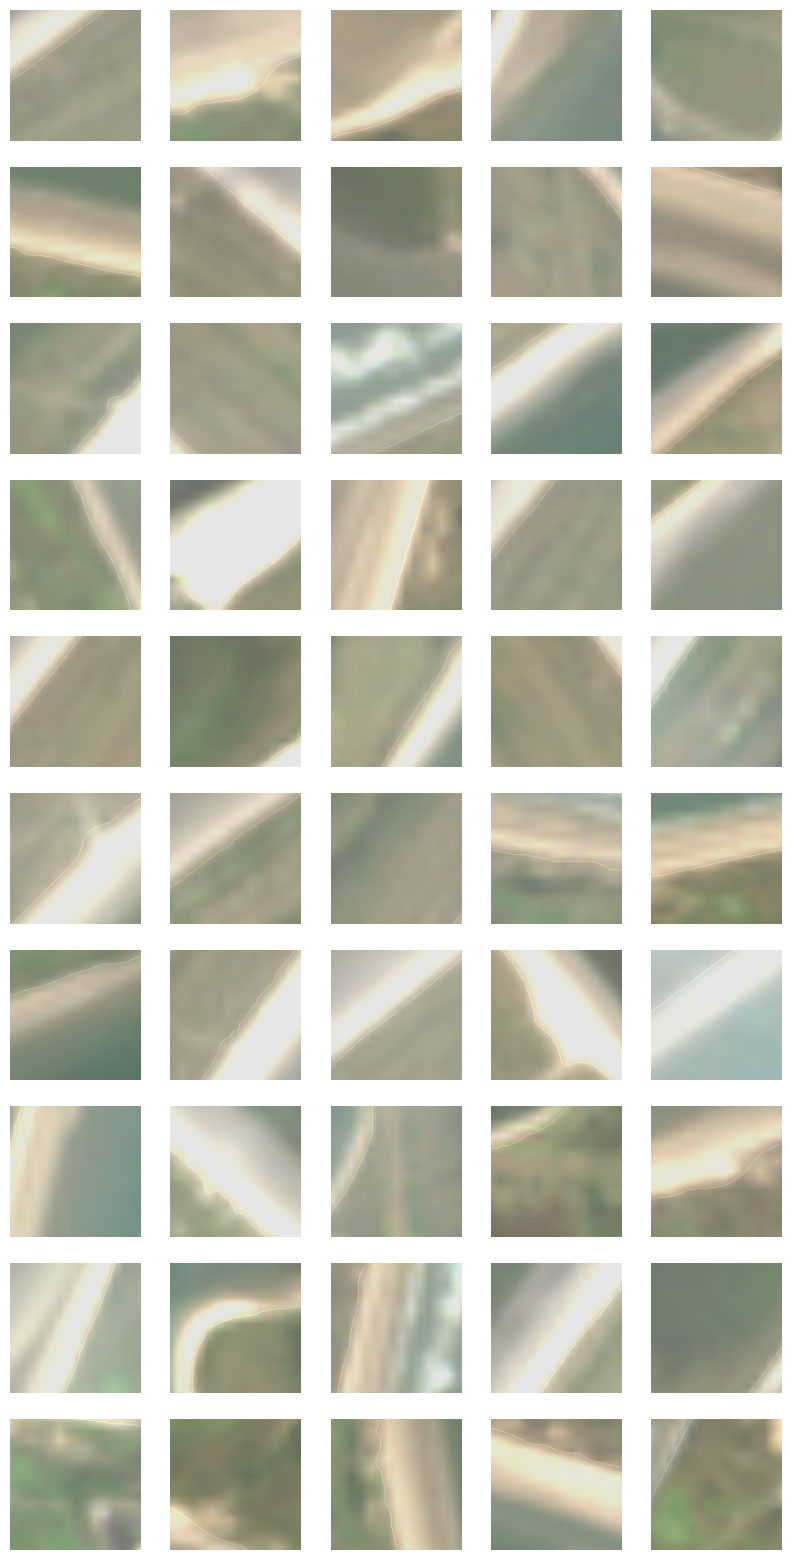

In [22]:
# Sense check training
training_files = glob.glob(os.path.join(data_path, "SIVE/training", "*.npy"))
print("Number of training files:", len(training_files))

fig,ax = plt.subplots(10, 5, figsize=(10, 20))
ax = ax.flatten().flatten()

for i in range(50):
    instance = np.load(random.choice(training_files))
    img_crop = instance[0:3, :, :]
    mask_crop = instance[4:5, :, :][0]
    rgb = utils.get_rgb(img_crop, contrast=0.3)
    ax[i].imshow(rgb)
    ax[i].imshow(mask_crop, alpha=0.1, cmap='gray')
    ax[i].axis('off')

In [32]:
np.shape(instance[0:4])
instance[4]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(144, 144), dtype=float32)

Number of test files: 196
Positive pixels in test set: 5661
Total pixels in test set: 1036800
Postive weight: 183.14785373608902


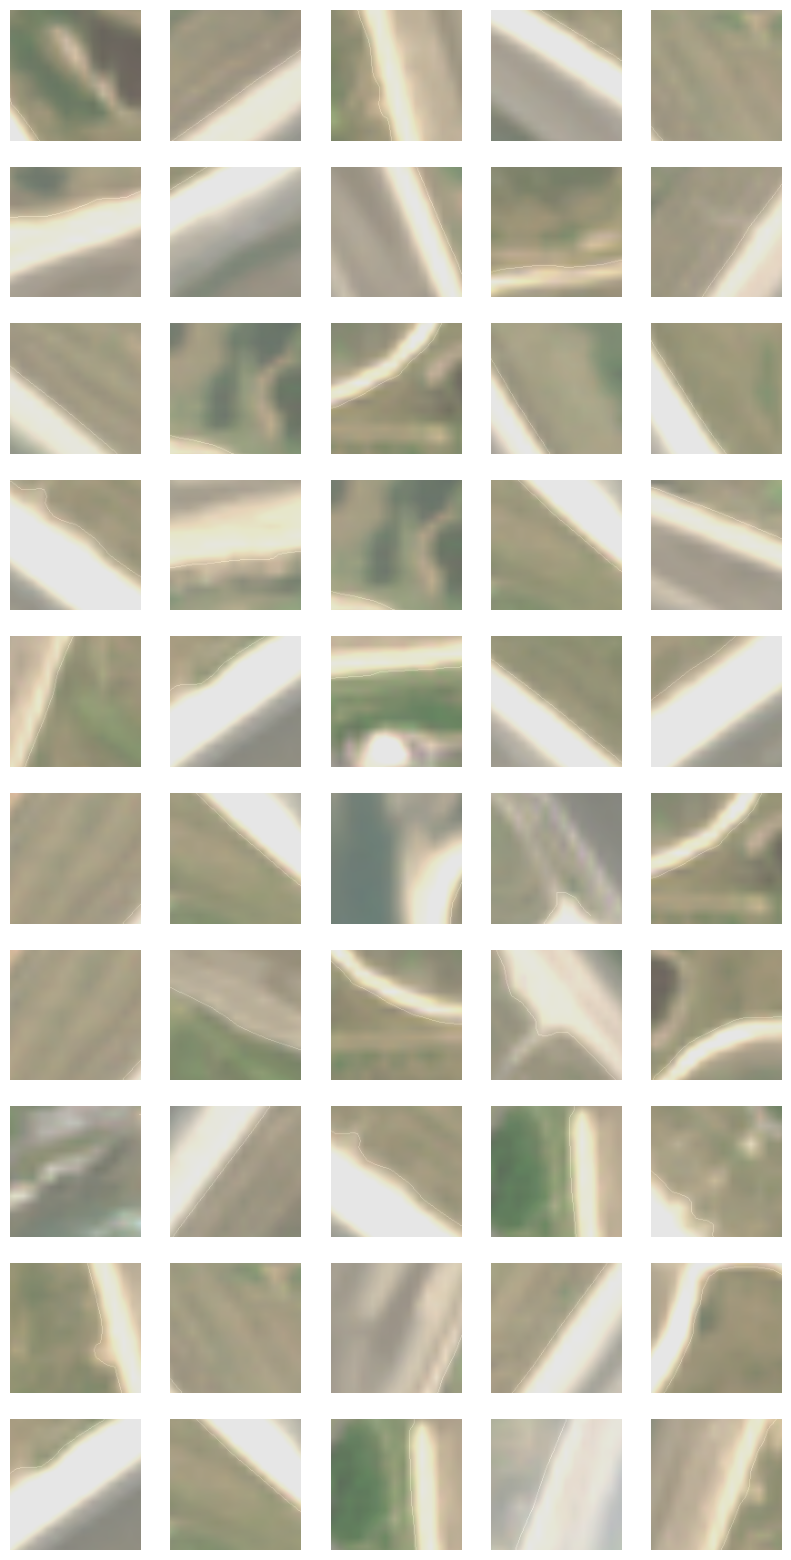

In [35]:
# Sense check training
test_files = glob.glob(os.path.join(data_path, "SIVE/test", "*.npy"))
print("Number of test files:", len(test_files))

fig,ax = plt.subplots(10, 5, figsize=(10, 20))
ax = ax.flatten().flatten()
positive = 0
total = 0
for i in range(50):
    instance = np.load(random.choice(test_files))
    positive += np.sum(instance[4] == 1)
    total += instance[4].shape[0] * instance[4].shape[1]
    img_crop = instance[0:4, :, :]
    mask_crop = instance[4]
    rgb = utils.get_rgb(img_crop, contrast=0.3)
    ax[i].imshow(rgb)
    ax[i].imshow(mask_crop, alpha=0.1, cmap='gray')
    ax[i].axis('off')

print("Positive pixels in test set:", positive)
print("Total pixels in test set:", total)
print("Postive weight:", total/positive)